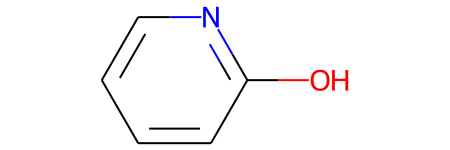

In [1]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
# Create mol object from smiles string
mol = Chem.MolFromSmiles('c1cccnc1O')
molSize=(450,150)
mc = Chem.Mol(mol.ToBinary())
if not mc.GetNumConformers():
    #Compute 2D coordinates
    rdDepictor.Compute2DCoords(mc)
# init the drawer with the size
drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
#draw the molcule
drawer.DrawMolecule(mc)
drawer.FinishDrawing()
# get the SVG string
svg = drawer.GetDrawingText()
# fix the svg string and display it
display(SVG(svg.replace('svg:','')))

In [2]:
!pip install sklearn

In [3]:
!pip install matplotlib

In [4]:
!pip install tqdm

In [5]:
!pip install xgboost

In [6]:
!pip install imblearn

In [7]:
!pip install requests

In [8]:
# Misc
from sklearn.model_selection import train_test_split
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Functions
from mlprocess import *
from params_by_label import *

# Fixing the seed
seed = 6
np.random.seed(seed)

""" Careful when importing saved dataframes with label names as indexes -> index = True """

' Careful when importing saved dataframes with label names as indexes -> index = True '

In [9]:
# Creating base df_molecules, df_y with the results vectors, and df_mols_descr with the descriptors
print("Creating Dataframes")
y_all, df_molecules = create_original_df(write_s=False)
df_molecules.drop("smiles", axis=1, inplace=True)
todrop = ["Product issues", "Investigations", "Social circumstances"]
y_all.drop(todrop, axis=1, inplace=True)  # No real connection with the molecule, multiple problems
out_names = y_all.columns.tolist()  # Get class labels

# Separating in a DF_mols_train and an Df_mols_test, in order to avoid data snooping and fitting the model to the test
df_mols_train, df_mols_test, y_train, y_test = train_test_split(df_molecules, y_all, test_size=0.2, random_state=seed)

Creating Dataframes


<AxesSubplot:title={'center':'Adverse Drug Reactions Counts'}>

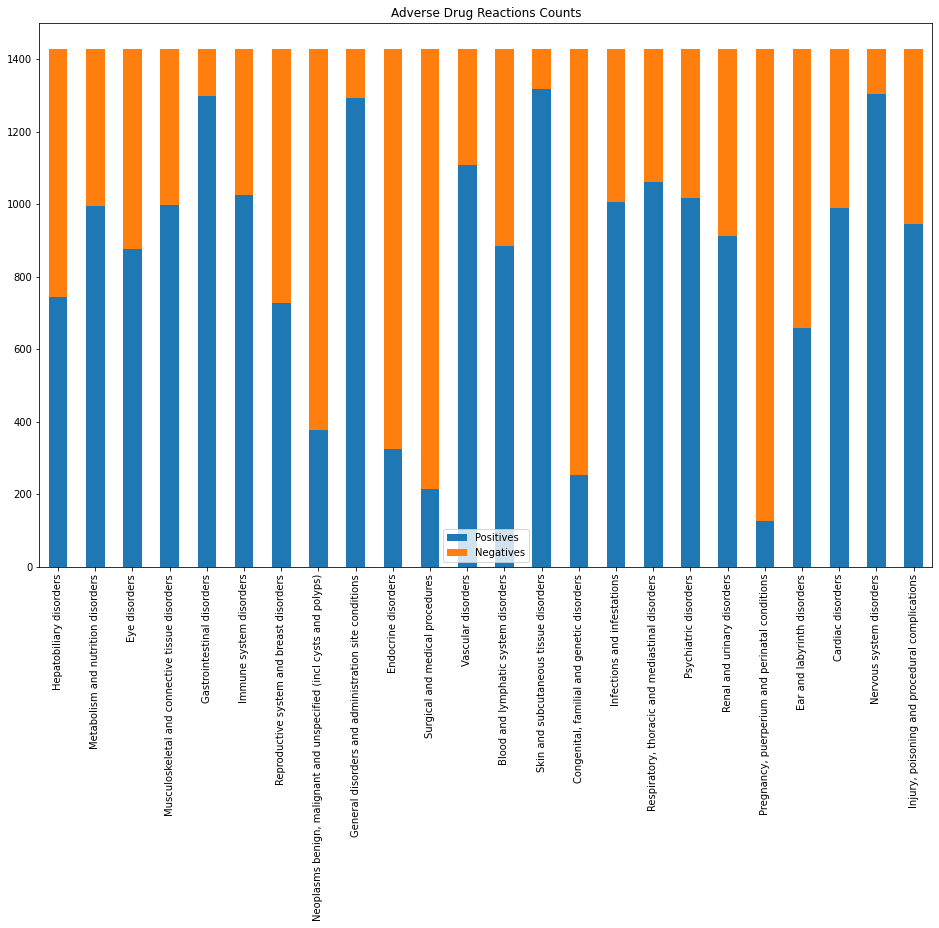

In [10]:
d = {"Positives": y_all.sum(axis=0), "Negatives": 1427 - y_all.sum(axis=0)}
countsm = pd.DataFrame(data=d)
countsm.plot(kind='bar', figsize=(16, 10), title="Adverse Drug Reactions Counts", ylim=(0, 1500), stacked=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [10:31<00:00, 31.60s/it]


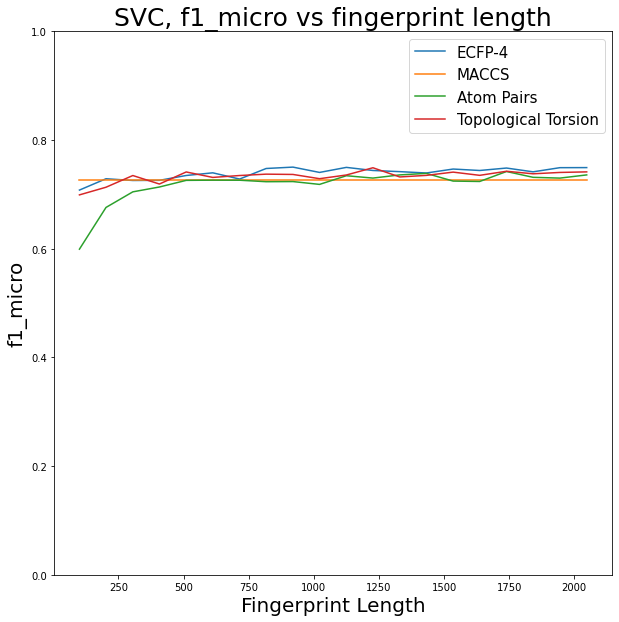

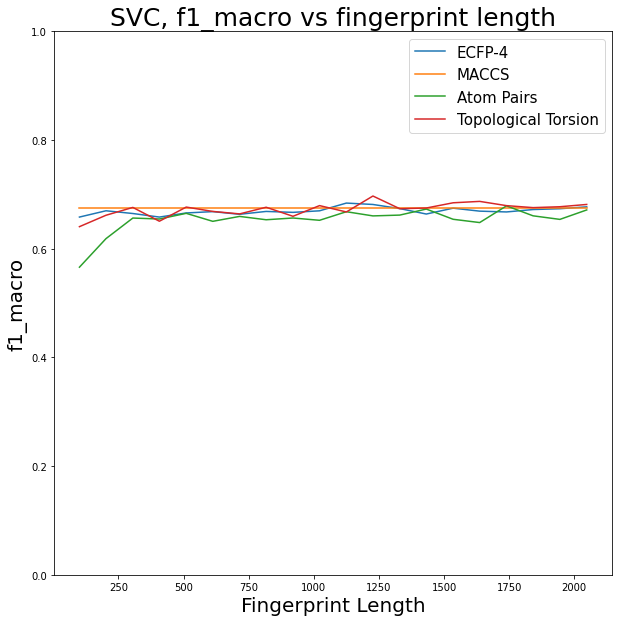

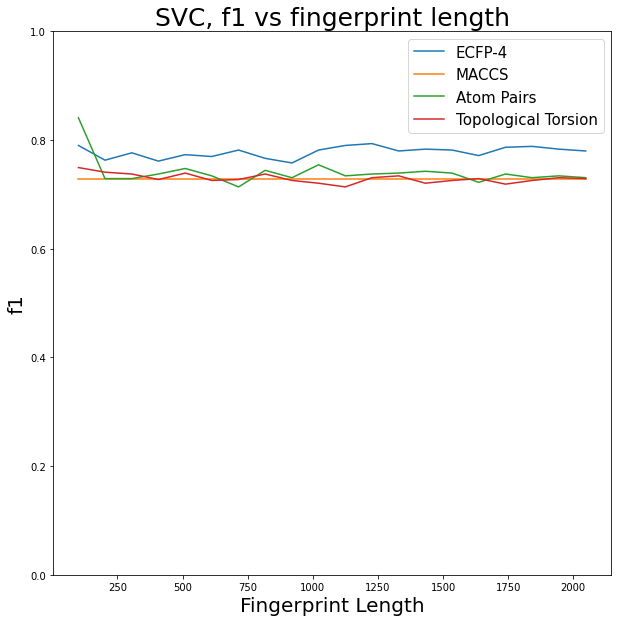

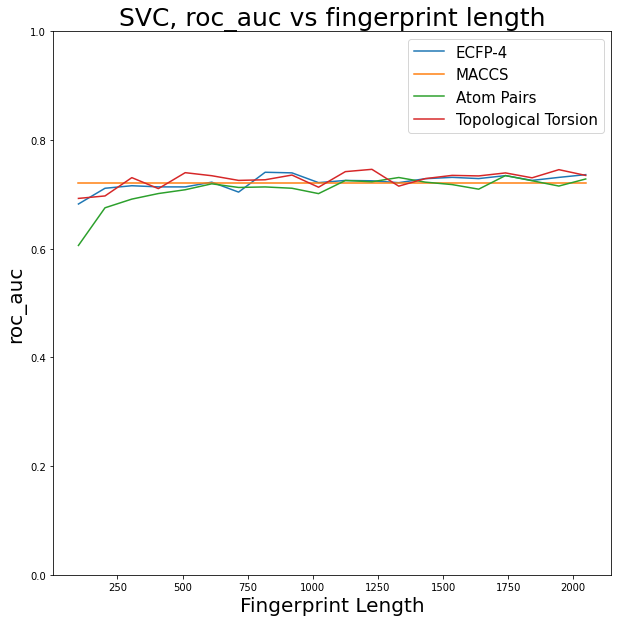

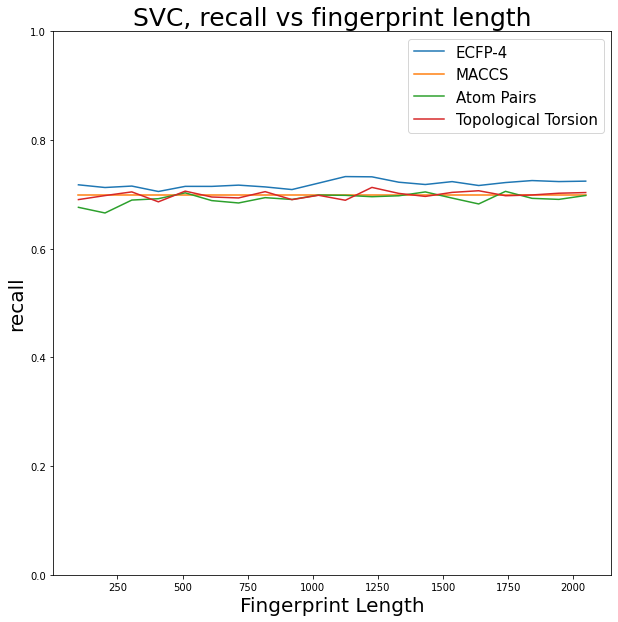

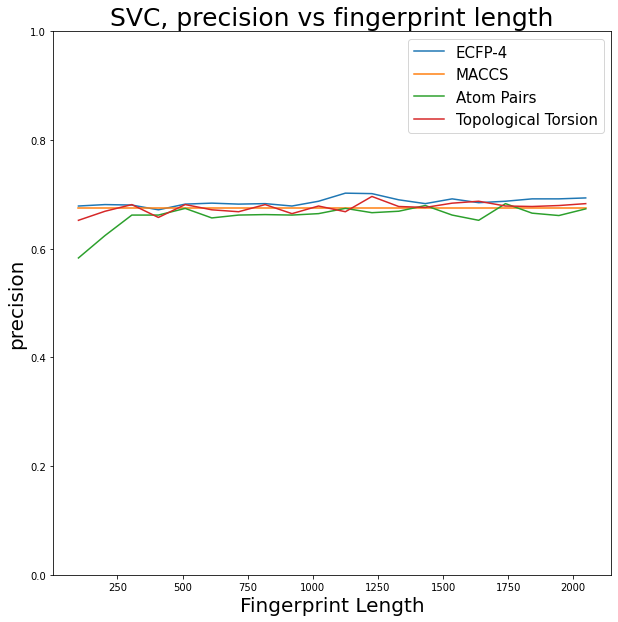

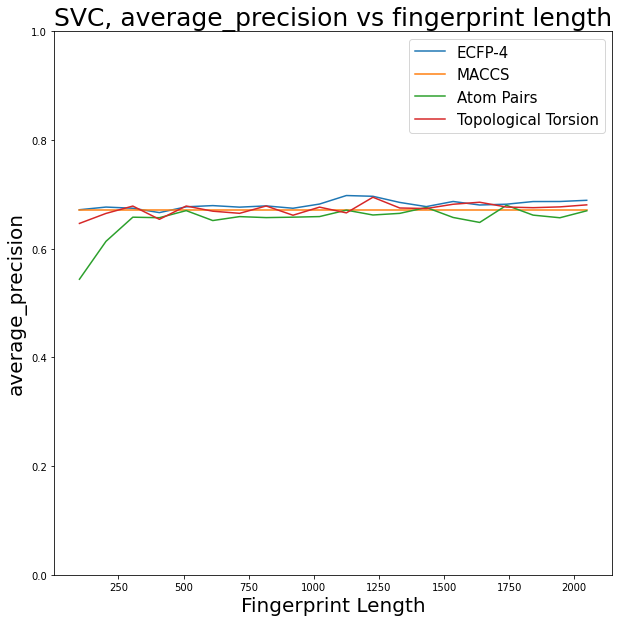

In [11]:
# Fingerprint length
all_df_results_svc = test_fingerprint_size(df_mols_train, y_train, SVC(gamma="scale", random_state=seed), makeplots=True, write=False)
# Best result with ECFP-4 at 1125 - This will be used to all results


In [12]:

# Create X datasets with fingerprint length
X_all, _, _, _ = createfingerprints(df_molecules, length=1125)
X_train_fp, _, _, _ = createfingerprints(df_mols_train, length=1125)
X_test_fp, _, _, _ = createfingerprints(df_mols_test, length=1125)

# Selects and create descriptors dataset
df_desc = createdescriptors(df_molecules)  # Create all descriptors

# Splits in train and test
df_desc_base_train, df_desc_base_test = train_test_split(df_desc, test_size=0.2, random_state=seed)

# Creates a dictionary with key = class label and value = dataframe with fingerprint + best K descriptors for that label
X_train_dic, X_test_dic, selected_cols = create_dataframes_dic(df_desc_base_train, df_desc_base_test, X_train_fp,
                                                               X_test_fp, y_train, out_names, score_func=f_classif, k=3)
# Creates a y dictionary for all labels
y_train_dic = {name: y_train[name] for name in out_names}
modelnamesvc = {name: "SVC" for name in out_names}
modelnamerf = {name: "RF" for name in out_names}
modelnamexgb = {name: "XGB" for name in out_names}
modelnamevot = {name: "VotingClassifier" for name in out_names}

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 67.23it/s]


In [13]:
print("Selected descriptors by label:")
pprint(selected_cols, width=-1)

Selected descriptors by label:
{'Blood and lymphatic system disorders': ['fracsp33',
                                          'aliphcarbocycles',
                                          'numsatcarbcycles'],
 'Cardiac disorders': ['arocarbocycles',
                       'arorings',
                       'numsatcarbcycles'],
 'Congenital, familial and genetic disorders': ['maxabspartcharge',
                                                'numrade',
                                                'arocarbocycles'],
 'Ear and labyrinth disorders': ['maxpartcharge',
                                 'aliphcarbocycles',
                                 'numsatcarbcycles'],
 'Endocrine disorders': ['numrade',
                         'aliphcarbocycles',
                         'numsatcarbcycles'],
 'Eye disorders': ['nhohcount',
                   'numhdonors',
                   'numhatoms'],
 'Gastrointestinal disorders': ['aliphcarbocycles',
                                'arorings'

In [14]:
print("SVC")
print("Base SVC without balancing:")
base_svc_report = cv_multi_report(X_train_dic, y_train, out_names, SVC(gamma="auto", random_state=seed), n_splits=5,
                                  n_jobs=-2, verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

SVC
Base SVC without balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:16<00:00,  3.19s/it]


In [15]:
print("Scores for SVC without balancing:")
base_svc_report

Scores for SVC without balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.712,0.643,0.622,0.676,0.851,0.612,0.660
Metabolism and nutrition disorders,0.818,0.692,0.409,0.565,1.000,0.692,0.732
Eye disorders,0.763,0.624,0.430,0.597,0.984,0.622,0.687
Musculoskeletal and connective tissue disorders,0.815,0.687,0.407,0.646,1.000,0.687,0.802
Gastrointestinal disorders,0.951,0.907,0.476,0.672,1.000,0.907,0.945
Immune system disorders,0.841,0.726,0.421,0.557,1.000,0.726,0.776
Reproductive system and breast disorders,0.609,0.608,0.608,0.652,0.611,0.608,0.625
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.000,0.745,0.427,0.679,0.000,0.000,0.470
General disorders and administration site conditions,0.953,0.910,0.476,0.597,1.000,0.910,0.938
Endocrine disorders,0.000,0.786,0.440,0.631,0.000,0.000,0.390


In [16]:
print("Base SVC with balancing:")
base_bal_svc_report = cv_multi_report(X_train_dic, y_train, out_names, SVC(gamma="auto", random_state=seed),
                                      balancing=True, n_splits=5, n_jobs=-2, verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Base SVC with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [26:40<00:00, 66.69s/it]


In [17]:
print("Scores for SVC with balancing:")
base_bal_svc_report

Scores for SVC with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.661,0.633,0.629,0.675,0.690,0.637,0.655
Metabolism and nutrition disorders,0.710,0.610,0.557,0.593,0.689,0.733,0.764
Eye disorders,0.704,0.609,0.562,0.609,0.759,0.658,0.697
Musculoskeletal and connective tissue disorders,0.730,0.637,0.588,0.632,0.713,0.748,0.776
Gastrointestinal disorders,0.906,0.835,0.606,0.723,0.881,0.933,0.956
Immune system disorders,0.785,0.675,0.557,0.590,0.819,0.755,0.789
Reproductive system and breast disorders,0.609,0.608,0.608,0.652,0.611,0.608,0.625
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.323,0.638,0.538,0.578,0.340,0.310,0.328
General disorders and administration site conditions,0.905,0.829,0.528,0.579,0.895,0.915,0.928
Endocrine disorders,0.273,0.699,0.541,0.555,0.262,0.289,0.285


In [18]:
diff_bal_svc = base_bal_svc_report - base_svc_report
print("Changes in scores after balancing:")
diff_bal_svc

Changes in scores after balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,-0.051,-0.010,0.007,-0.001,-0.161,0.025,-0.005
Metabolism and nutrition disorders,-0.108,-0.082,0.148,0.028,-0.311,0.041,0.032
Eye disorders,-0.059,-0.015,0.132,0.012,-0.225,0.036,0.010
Musculoskeletal and connective tissue disorders,-0.085,-0.050,0.181,-0.014,-0.287,0.061,-0.026
Gastrointestinal disorders,-0.045,-0.072,0.130,0.051,-0.119,0.026,0.011
Immune system disorders,-0.056,-0.051,0.136,0.033,-0.181,0.029,0.013
Reproductive system and breast disorders,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.323,-0.107,0.111,-0.101,0.340,0.310,-0.142
General disorders and administration site conditions,-0.048,-0.081,0.052,-0.018,-0.105,0.005,-0.010
Endocrine disorders,0.273,-0.087,0.101,-0.076,0.262,0.289,-0.105


As we can see by some of the results that are displayed in the previous tables, even though Average Precision didn't change by much, the biggest change of all the metrics was in the F1 Macro score. As this is the unweighted mean of F1 score to both negative and positive classes, we can conclude that an improvement of the F1 score in the minority class was the main consequence of the oversampling, as was to be expected.

With these positive results, oversampling was applied when developing every model.

The next step in the model development was hyperparameter optimization. In SVC, two parameters were optimized using grid search with cross-validation - C and gamma - while using a Radial Basis Function (RBF) kernel, where C is the cost of misclassifying training examples and gamma is a specific parameter of RBF kernel and can be seen as the inverse of the radius of influence of the samples selected as support vectors.

In [19]:
# Searching best parameters
params_to_test = {"svc__kernel": ["rbf"], "svc__C": [0.01, 0.1, 1, 10],
                  "svc__gamma": [0.001, 0.01, 0.1, 1]}
d_params_to_test = {name: params_to_test for name in out_names}

"""The following code was previously executed and its output was saved"""
#best_SVC_params_by_label = multi_label_grid_search(X_train_dic, y_train, out_names[15:],
#                                                   SVC(gamma="auto", random_state=seed), d_params_to_test,
#                                                   balancing=True, n_splits=5, scoring="f1_micro", n_jobs=-2,
#                                                   verbose=True, random_state=seed)
pprint(best_SVC_params_by_label, width=-1)

{'Blood and lymphatic system disorders': {'svc__C': 10,
                                          'svc__gamma': 0.01,
                                          'svc__kernel': 'rbf'},
 'Cardiac disorders': {'svc__C': 10,
                       'svc__gamma': 0.1,
                       'svc__kernel': 'rbf'},
 'Congenital, familial and genetic disorders': {'svc__C': 0.01,
                                                'svc__gamma': 1,
                                                'svc__kernel': 'rbf'},
 'Ear and labyrinth disorders': {'svc__C': 10,
                                 'svc__gamma': 0.01,
                                 'svc__kernel': 'rbf'},
 'Endocrine disorders': {'svc__C': 0.01,
                         'svc__gamma': 1,
                         'svc__kernel': 'rbf'},
 'Eye disorders': {'svc__C': 10,
                   'svc__gamma': 0.1,
                   'svc__kernel': 'rbf'},
 'Gastrointestinal disorders': {'svc__C': 0.01,
                                'svc__gamma'

In [20]:
print("Improved SVC with balancing:")
impr_bal_svc_report = cv_multi_report(X_train_dic, y_train, out_names, modelname=modelnamesvc,
                                      spec_params=best_SVC_params_by_label, balancing=True, n_splits=5, n_jobs=-2,
                                      verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Improved SVC with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [37:08<00:00, 92.85s/it]


In [21]:
print("Scores for optimized SVC with balancing:")
impr_bal_svc_report

Scores for optimized SVC with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.712,0.684,0.680,0.729,0.758,0.674,0.699
Metabolism and nutrition disorders,0.809,0.692,0.508,0.596,0.942,0.709,0.757
Eye disorders,0.755,0.639,0.534,0.633,0.907,0.647,0.721
Musculoskeletal and connective tissue disorders,0.811,0.703,0.554,0.669,0.929,0.721,0.798
Gastrointestinal disorders,0.951,0.907,0.476,0.618,1.000,0.907,0.928
Immune system disorders,0.840,0.734,0.533,0.612,0.958,0.748,0.793
Reproductive system and breast disorders,0.677,0.680,0.679,0.726,0.672,0.684,0.722
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.000,0.745,0.427,0.649,0.000,0.000,0.346
General disorders and administration site conditions,0.953,0.910,0.476,0.588,1.000,0.910,0.931
Endocrine disorders,0.000,0.786,0.440,0.573,0.000,0.000,0.263


3.2.2 Random Forest

The workflow to develop the RF model was the same as the SVC, as shown previously.

In [22]:
print("Random Forest")
print("Base RF without balancing:")
base_rf_report = cv_multi_report(X_train_dic, y_train, out_names,
                                 RandomForestClassifier(n_estimators=100, random_state=seed), n_splits=5, n_jobs=-2,
                                 verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Random Forest
Base RF without balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.40s/it]


In [23]:
print("Scores for RF without balancing:")
base_rf_report

Scores for RF without balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.723,0.700,0.698,0.756,0.754,0.694,0.737
Metabolism and nutrition disorders,0.802,0.687,0.527,0.582,0.915,0.714,0.744
Eye disorders,0.747,0.660,0.613,0.655,0.823,0.685,0.733
Musculoskeletal and connective tissue disorders,0.804,0.699,0.573,0.662,0.902,0.726,0.800
Gastrointestinal disorders,0.949,0.904,0.524,0.704,0.990,0.911,0.948
Immune system disorders,0.822,0.708,0.507,0.594,0.928,0.738,0.790
Reproductive system and breast disorders,0.681,0.679,0.679,0.738,0.685,0.678,0.740
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.327,0.777,0.597,0.717,0.213,0.739,0.498
General disorders and administration site conditions,0.951,0.906,0.501,0.608,0.993,0.912,0.932
Endocrine disorders,0.262,0.791,0.570,0.700,0.172,0.563,0.430


In [24]:
print("Base RF with balancing:")
base_bal_rf_report = cv_multi_report(X_train_dic, y_train, out_names,
                                     RandomForestClassifier(n_estimators=100, random_state=seed), balancing=True,
                                     n_splits=5, n_jobs=-2, verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Base RF with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [25:16<00:00, 63.18s/it]


In [25]:
print("Scores for RF with balancing:")
base_bal_rf_report

Scores for RF with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.728,0.713,0.711,0.755,0.744,0.714,0.734
Metabolism and nutrition disorders,0.770,0.661,0.562,0.603,0.818,0.727,0.767
Eye disorders,0.724,0.645,0.612,0.661,0.761,0.691,0.744
Musculoskeletal and connective tissue disorders,0.781,0.685,0.608,0.682,0.818,0.749,0.815
Gastrointestinal disorders,0.944,0.896,0.621,0.724,0.962,0.926,0.954
Immune system disorders,0.808,0.706,0.587,0.627,0.855,0.766,0.809
Reproductive system and breast disorders,0.670,0.670,0.670,0.733,0.671,0.671,0.735
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.370,0.749,0.607,0.690,0.292,0.512,0.426
General disorders and administration site conditions,0.938,0.884,0.539,0.627,0.961,0.916,0.938
Endocrine disorders,0.302,0.777,0.584,0.646,0.225,0.472,0.352


It was possible to see that the base RF model performed not only better than the base SVC model for most of the classification tasks, it also out-performed the optimized SVC model in some of these. It also improved after oversampling the minority class.

The hyperparameter optimization in this model was done by cross-validation random search using at least 150 combinations of the parameters. The selection of random search instead of grid search was done because of the multiple possible combinations with every parameter.

In RF, six parameters were considered:
n_estimators - number of trees in the forest;
max_features - number of features to consider when looking for the best split;
max_depth - maximum depth of the tree;
min_samples_split - minimum number of samples required to split a node;
min_samples_leaf - minimum number of samples required to be a leaf node;
bootstrap - whether to use bootstrap samples or the whole dataset to build each tree.

In [26]:
# Searching best parameters
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
max_features = ["log2", "sqrt"]
max_depth = [50, 90, 130, 170, 210, 250]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2]
bootstrap = [True, False]
rf_grid = {"randomforestclassifier__n_estimators": n_estimators,
           "randomforestclassifier__max_features": max_features,
           "randomforestclassifier__max_depth": max_depth,
           "randomforestclassifier__min_samples_split": min_samples_split,
           "randomforestclassifier__min_samples_leaf": min_samples_leaf,
           "randomforestclassifier__bootstrap": bootstrap}
rf_grid_label = {name: rf_grid for name in out_names}

"""The following code was previously executed and its output was saved"""
# best_RF_params_by_label = multi_label_random_search(X_train_dic, y_train, out_names[20:],
#                                                     RandomForestClassifier(random_state=seed), rf_grid_label,
#                                                     balancing=True, n_splits=3, scoring="f1_micro", n_jobs=-2,
#                                                     verbose=True, random_state=seed, n_iter=150)
pprint(best_RF_params_by_label, width=-1)

{'Blood and lymphatic system disorders': {'randomforestclassifier__bootstrap': False,
                                          'randomforestclassifier__max_depth': 50,
                                          'randomforestclassifier__max_features': 'log2',
                                          'randomforestclassifier__min_samples_leaf': 2,
                                          'randomforestclassifier__min_samples_split': 10,
                                          'randomforestclassifier__n_estimators': 600},
 'Cardiac disorders': {'randomforestclassifier__bootstrap': False,
                       'randomforestclassifier__max_depth': 210,
                       'randomforestclassifier__max_features': 'sqrt',
                       'randomforestclassifier__min_samples_leaf': 1,
                       'randomforestclassifier__min_samples_split': 5,
                       'randomforestclassifier__n_estimators': 700},
 'Congenital, familial and genetic disorders': {'randomfores

In [27]:
print("Improved RF with balancing:")
impr_bal_rf_report = cv_multi_report(X_train_dic, y_train, out_names, modelname=modelnamerf,
                                     spec_params=best_RF_params_by_label, balancing=True, n_splits=5, n_jobs=-2,
                                     verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Improved RF with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [26:11<00:00, 65.48s/it]


In [28]:
print("Scores for optimized RF with balancing:")
impr_bal_rf_report

Scores for optimized RF with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.728,0.711,0.709,0.758,0.749,0.710,0.741
Metabolism and nutrition disorders,0.780,0.671,0.561,0.605,0.846,0.725,0.760
Eye disorders,0.757,0.673,0.628,0.678,0.831,0.696,0.754
Musculoskeletal and connective tissue disorders,0.793,0.692,0.593,0.686,0.858,0.737,0.826
Gastrointestinal disorders,0.945,0.897,0.594,0.726,0.971,0.920,0.951
Immune system disorders,0.810,0.703,0.564,0.633,0.872,0.756,0.815
Reproductive system and breast disorders,0.676,0.673,0.673,0.744,0.685,0.669,0.753
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.392,0.766,0.624,0.715,0.299,0.575,0.447
General disorders and administration site conditions,0.941,0.890,0.561,0.636,0.965,0.918,0.942
Endocrine disorders,0.296,0.781,0.583,0.677,0.217,0.485,0.388


3.2.3 XGBoost Model (XGB)
The same workflow as before was applied to XGB.

In [29]:
print("XGB")
print("Base XGB without balancing:")
base_xgb_report = cv_multi_report(X_train_dic, y_train, out_names,
                                  xgb.XGBClassifier(objective="binary:logistic", random_state=seed), n_splits=5,
                                  n_jobs=-2, verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

XGB
Base XGB without balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [03:23<00:00,  8.48s/it]


In [30]:
base_xgb_report

,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.691,0.677,0.677,0.717,0.697,0.685,0.697
Metabolism and nutrition disorders,0.762,0.642,0.520,0.557,0.827,0.707,0.739
Eye disorders,0.706,0.621,0.587,0.631,0.743,0.673,0.709
Musculoskeletal and connective tissue disorders,0.775,0.676,0.595,0.657,0.815,0.740,0.790
Gastrointestinal disorders,0.946,0.898,0.549,0.714,0.980,0.914,0.951
Immune system disorders,0.787,0.670,0.531,0.584,0.837,0.742,0.799
Reproductive system and breast disorders,0.660,0.658,0.658,0.720,0.665,0.656,0.719
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.375,0.751,0.610,0.686,0.295,0.523,0.455
General disorders and administration site conditions,0.945,0.897,0.525,0.654,0.979,0.914,0.944
Endocrine disorders,0.325,0.781,0.597,0.645,0.246,0.488,0.391


In [31]:
print("Base XGB with balancing:")
base_bal_xgb_report = cv_multi_report(X_train_dic, y_train, out_names,
                                      xgb.XGBClassifier(objective="binary:logistic", random_state=seed), balancing=True,
                                      n_splits=5, n_jobs=-2, verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Base XGB with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [29:38<00:00, 74.09s/it]


In [32]:
base_bal_xgb_report

,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.680,0.667,0.666,0.723,0.685,0.676,0.703
Metabolism and nutrition disorders,0.739,0.625,0.535,0.560,0.767,0.713,0.738
Eye disorders,0.719,0.641,0.610,0.647,0.750,0.691,0.721
Musculoskeletal and connective tissue disorders,0.762,0.663,0.591,0.638,0.783,0.742,0.777
Gastrointestinal disorders,0.935,0.881,0.601,0.712,0.946,0.925,0.951
Immune system disorders,0.791,0.687,0.583,0.627,0.816,0.768,0.813
Reproductive system and breast disorders,0.666,0.663,0.663,0.714,0.672,0.662,0.715
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.434,0.739,0.632,0.686,0.392,0.487,0.454
General disorders and administration site conditions,0.934,0.877,0.541,0.677,0.952,0.917,0.949
Endocrine disorders,0.336,0.751,0.591,0.630,0.291,0.402,0.378


The hyperparameter optimization in XGB was done in a similar way to RF: cross-validation random search with at least 150 combinations of parameters. In this model, six parameters were considered:
eta - step size of the model;
min_child_weight - minimum number of instances needed to be in each node;
max_depth - maximum depth of a tree;
gamma - minimum loss reduction required to make a further partition;
subsample - subsample ratio of the training instance;
colsample_bytree - subsample ratio of features when constructing each tree.

In [33]:
eta = [0.05, 0.1, 0.2]
min_child_weight = [1, 3]
max_depth = [5, 7, 9]
gamma = [0, 0.1, 0.2, 0.3, 0.4]
subsample = [0.6, 0.7, 0.8, 0.9]
colsample_bytree = [0.6, 0.7, 0.8, 0.9]
xgb_grid = {"xgbclassifier__eta": eta,
            "xgbclassifier__min_child_weight": min_child_weight,
            "xgbclassifier__max_depth": max_depth,
            "xgbclassifier__gamma": gamma,
            "xgbclassifier__subsample": subsample,
            "xgbclassifier__colsample_bytree": colsample_bytree
            }
xgb_grid_label = {name: xgb_grid for name in out_names}

"""The following code was previously executed and its output was saved"""
# best_xgb_params_by_label = multi_label_random_search(X_train_dic, y_train, out_names[20:],
#                                                      xgb.XGBClassifier(objective="binary:logistic", random_state=seed),
#                                                      xgb_grid_label, balancing=True, n_splits=3, scoring="f1_micro",
#                                                      n_jobs=-2, verbose=True, random_state=seed, n_iter=150)


'The following code was previously executed and its output was saved'

In [34]:
print("Improved XGB with balancing:")
impr_bal_xgb_report = cv_multi_report(X_train_dic, y_train, out_names, modelname=modelnamexgb,
                                      spec_params=best_xgb_params_by_label, balancing=True, n_splits=5, n_jobs=-2,
                                      verbose=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Improved XGB with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [29:33<00:00, 73.89s/it]


In [35]:
impr_bal_xgb_report

,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.681,0.668,0.667,0.727,0.686,0.676,0.706
Metabolism and nutrition disorders,0.746,0.632,0.537,0.591,0.782,0.714,0.752
Eye disorders,0.717,0.642,0.613,0.650,0.743,0.693,0.731
Musculoskeletal and connective tissue disorders,0.760,0.658,0.583,0.644,0.786,0.736,0.791
Gastrointestinal disorders,0.939,0.888,0.611,0.715,0.954,0.925,0.948
Immune system disorders,0.781,0.672,0.562,0.621,0.808,0.757,0.817
Reproductive system and breast disorders,0.658,0.658,0.658,0.718,0.660,0.657,0.725
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.380,0.724,0.601,0.666,0.333,0.443,0.406
General disorders and administration site conditions,0.935,0.879,0.535,0.670,0.956,0.915,0.949
Endocrine disorders,0.332,0.762,0.594,0.629,0.274,0.427,0.368


One observed pattern was the improvement with XGB when classifying labels where the positive examples were the minority class.



3.2.4 Final Model Selection and Evaluation
After developing these three models for each label, it was possible to observe that different models perform better for different tasks. As such, after observing the different metrics, it was manually selected, mainly by comparing Average Precision, F1 Binary and Macro, and Recall, the best model for each.

In [36]:
pprint(best_model_by_label)

{'Blood and lymphatic system disorders': 'RF',
 'Cardiac disorders': 'RF',
 'Congenital, familial and genetic disorders': 'XGB',
 'Ear and labyrinth disorders': 'SVC',
 'Endocrine disorders': 'XGB',
 'Eye disorders': 'RF',
 'Gastrointestinal disorders': 'RF',
 'General disorders and administration site conditions': 'RF',
 'Hepatobiliary disorders': 'RF',
 'Immune system disorders': 'SVC',
 'Infections and infestations': 'RF',
 'Injury, poisoning and procedural complications': 'RF',
 'Metabolism and nutrition disorders': 'RF',
 'Musculoskeletal and connective tissue disorders': 'RF',
 'Neoplasms benign, malignant and unspecified (incl cysts and polyps)': 'XGB',
 'Nervous system disorders': 'RF',
 'Pregnancy, puerperium and perinatal conditions': 'XGB',
 'Psychiatric disorders': 'RF',
 'Renal and urinary disorders': 'RF',
 'Reproductive system and breast disorders': 'RF',
 'Respiratory, thoracic and mediastinal disorders': 'RF',
 'Skin and subcutaneous tissue disorders': 'RF',
 'Surgical

In [37]:
scores_best_model = cv_multi_report(X_train_dic, y_train, out_names, modelname=best_model_by_label,
                                    spec_params=best_model_params_by_label, balancing=True, n_splits=5, n_jobs=-2,
                                    verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [28:55<00:00, 72.31s/it]


In [38]:
print("CV scores for best model by label")
scores_best_model

CV scores for best model by label


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.731,0.708,0.706,0.759,0.764,0.701,0.740
Metabolism and nutrition disorders,0.781,0.674,0.568,0.608,0.843,0.729,0.762
Eye disorders,0.747,0.662,0.618,0.676,0.814,0.690,0.753
Musculoskeletal and connective tissue disorders,0.792,0.692,0.600,0.683,0.851,0.741,0.822
Gastrointestinal disorders,0.945,0.898,0.599,0.728,0.971,0.921,0.953
Immune system disorders,0.839,0.734,0.531,0.612,0.958,0.747,0.794
Reproductive system and breast disorders,0.677,0.674,0.674,0.742,0.685,0.671,0.752
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.369,0.721,0.595,0.666,0.320,0.438,0.408
General disorders and administration site conditions,0.942,0.892,0.562,0.632,0.967,0.919,0.940
Endocrine disorders,0.332,0.766,0.595,0.638,0.270,0.435,0.376


After this selection, the respective models were tested using the test dataset and the results of some of the metrics are shown in following table.

In [39]:
print("Test scores for best model by label")
test_scores_best_model = test_score_multi_report(X_train_dic, y_train, X_test_dic, y_test, out_names,
                                                 modelname=best_model_by_label, spec_params=best_model_params_by_label,
                                                 random_state=seed, verbose=False, balancing=True, n_jobs=-2, plot=False)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Test scores for best model by label


 29%|████████████████████████▏                                                          | 7/24 [05:38<14:26, 50.97s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 38%|███████████████████████████████▏                                                   | 9/24 [07:43<14:26, 57.78s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 42%|██████████████████████████████████▏                                               | 10/24 [08:37<13:13, 56.68s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 58%|███████████████████████████████████████████████▊                                  | 14/24 [12:52<10:14, 61.46s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:08:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [16:59<04:04, 48.95s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [21:35<00:00, 53.98s/it]


In [40]:
test_scores_best_model

,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Prec-Rec
Hepatobiliary disorders,0.712,0.671,0.665,0.665,0.758,0.671,0.773
Metabolism and nutrition disorders,0.823,0.724,0.596,0.590,0.893,0.763,0.810
Eye disorders,0.764,0.678,0.629,0.628,0.847,0.696,0.809
Musculoskeletal and connective tissue disorders,0.857,0.773,0.651,0.636,0.915,0.806,0.858
Gastrointestinal disorders,0.957,0.920,0.608,0.579,0.985,0.932,0.977
Immune system disorders,0.821,0.713,0.551,0.568,0.959,0.718,0.794
Reproductive system and breast disorders,0.721,0.689,0.685,0.684,0.737,0.706,0.806
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.386,0.689,0.589,0.585,0.329,0.467,0.478
General disorders and administration site conditions,0.925,0.860,0.486,0.498,0.965,0.888,0.929
Endocrine disorders,0.413,0.741,0.623,0.614,0.329,0.553,0.501


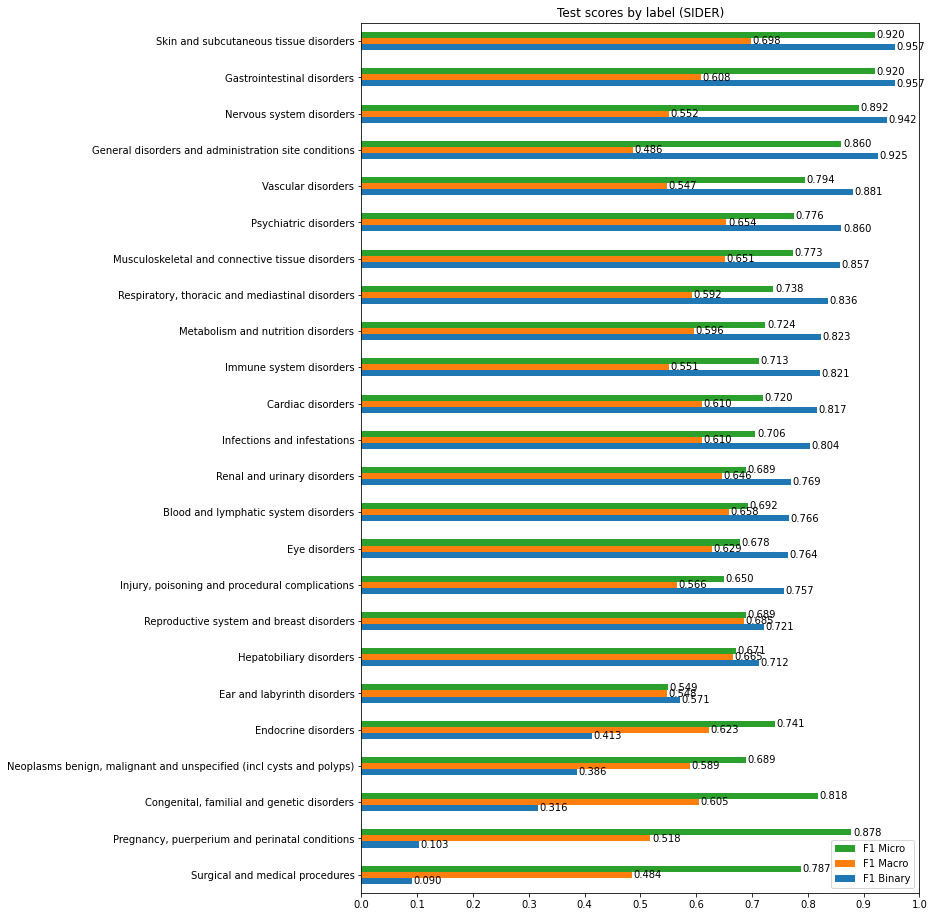

In [41]:
test_scores_best_model_sorted = test_scores_best_model.sort_values(by=["F1 Binary"], ascending=True)
ax = test_scores_best_model_sorted.plot(kind="barh",
                                        y=["F1 Binary", "F1 Macro", "F1 Micro"],
                                        title="Test scores by label (SIDER)",
                                        xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                        legend="reverse", xlim=(0, 1), figsize = (10,16))
for p in ax.patches: ax.annotate("{:.3f}".format(round(p.get_width(), 3)), (p.get_x() + p.get_width(), p.get_y()),
                                 xytext=(30, 0), textcoords='offset points', horizontalalignment='right')

As we can see, the results vary widely from label to label. In order to better understand the reason why, we can further analyse the three different categories of results: high F1, low F1 Macro; similar F1 and F1 Macro; and low F1 and F1 Macro. It is possible to observe these three results, for example, in "General disorders and administration site conditions", "Hepatobiliary disorders", and "Congenital, familial and genetic disorders", respectively. One of the possible explanations for this is the distribution of positive and negative examples in the dataset, observable in the following table:

In [42]:
df_perc = countsm / 1427
df_filt = df_perc.loc[["General disorders and administration site conditions","Hepatobiliary disorders",
                       "Congenital, familial and genetic disorders"]]*100
df_filt.apply(lambda x: round(x, 1)).rename(columns = lambda x: "% "+x)

,% Positives,% Negatives
General disorders and administration site conditions,90.5,9.5
Hepatobiliary disorders,52.1,47.9
"Congenital, familial and genetic disorders",17.7,82.3


In the second type of result, for "Hepatobiliary disorders", similar values can be observed across the metrics. This is the result of the more balanced distribution of the label in the dataset, and, as such, we have a good F1 score for both positive and negative labels, shown by the F1 Macro score. However, for the other two types of results, "General disorders..." and "Congenital...", it is possible to see a much bigger difference across the metrics. With the first one, as almost 91% of the examples in the dataset are positive, and while oversampling helped, it is still possible to observe that the model tends to classify most of the validation examples as positive. It has a very high recall, so every positive example was correctly classified as positive and the high precision could lead us to believe that this is mostly correct but, as it is possible to see by the low F1 Macro score, the F1 for the negative label is very low. This means that the model is classifying most of the examples as positive, but because of the imbalance in the dataset in favour of the positive examples, the precision is still high. The opposite is true when looking at "Congenital...", in this case, the imbalance is in favour of the negative label so the model tends to classify samples as negative.

There are two conclusions that can already be made about the performance of the models: RF had the overall best performance across the board with a majority of labels having this model as the best, and, in labels with very few positive examples, the best model was always the XGB.

When looking at the performance for each label, it is clear that the best performance came from the more balanced labels. While these labels didn't have the best F1 Binary Score, and, as such, the recall is lower than others, they had the best performance when separating positive and negative classifications, showed by having a similar F1 Binary and Macro score.

3.2.5 OFFSIDES


This dataset was used in order to try to expand the number of examples and, consequently, improve the models' performance.


One of the first apparent problems when analysing this dataset was the even greater imbalance in the dataset, as seen next:

<AxesSubplot:title={'center':'OFFSIDES Adverse Drug Reactions Counts'}>

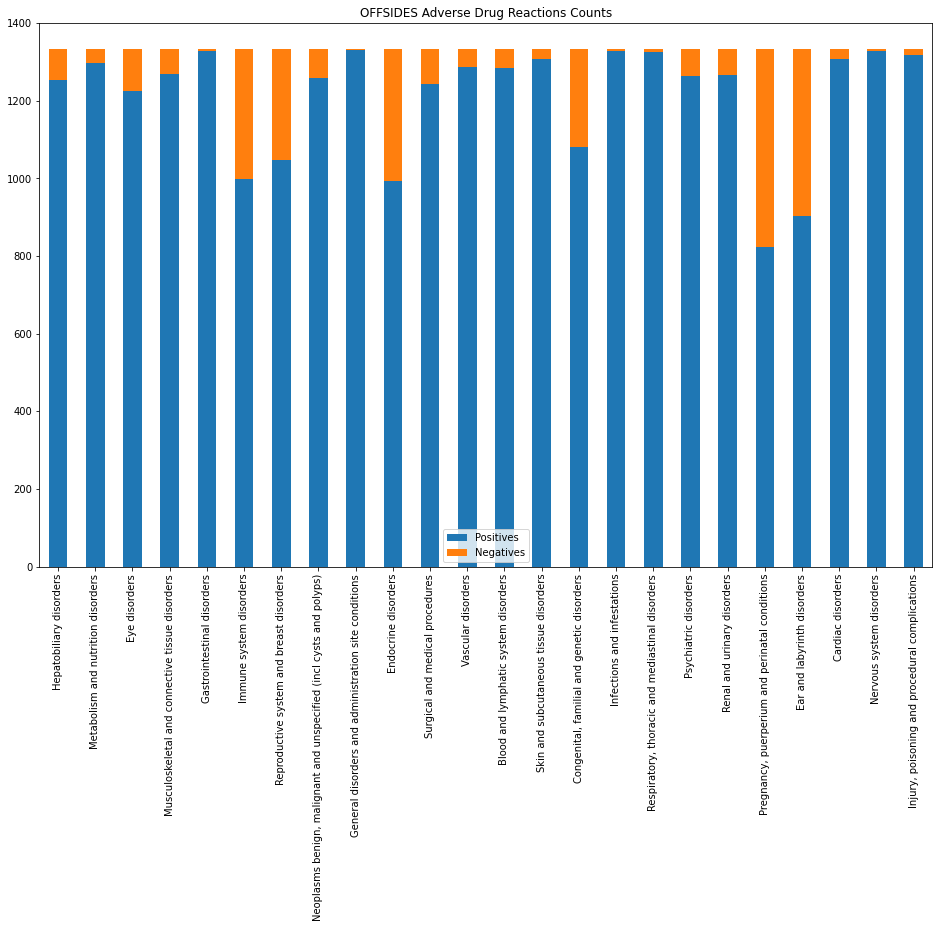

In [43]:
mod_off = pd.read_csv("./datasets/offside_socs_modified.csv")
df = pd.read_csv("./datasets/sider.csv")
todrop = ["Product issues", "Investigations", "Social circumstances"]
df.drop(todrop, axis=1, inplace=True)

# 1332 Rows in Total
df_y_2 = mod_off.drop("smiles", axis=1)
d2 = {"Positives": df_y_2.sum(axis=0), "Negatives": 1332 - df_y_2.sum(axis=0)}
counts = pd.DataFrame(data=d2)
counts.plot(kind='bar', figsize=(16, 10), title="OFFSIDES Adverse Drug Reactions Counts", ylim=(0, 1400), stacked=True)

This dataset was then combined with SIDER, considering a label present in both datasets as positive when it was positive in either OFFSIDES or SIDER, and the new global counts are present next:

<AxesSubplot:title={'center':'Adverse Drug Reactions Counts (SIDER + OFFSIDES)'}>

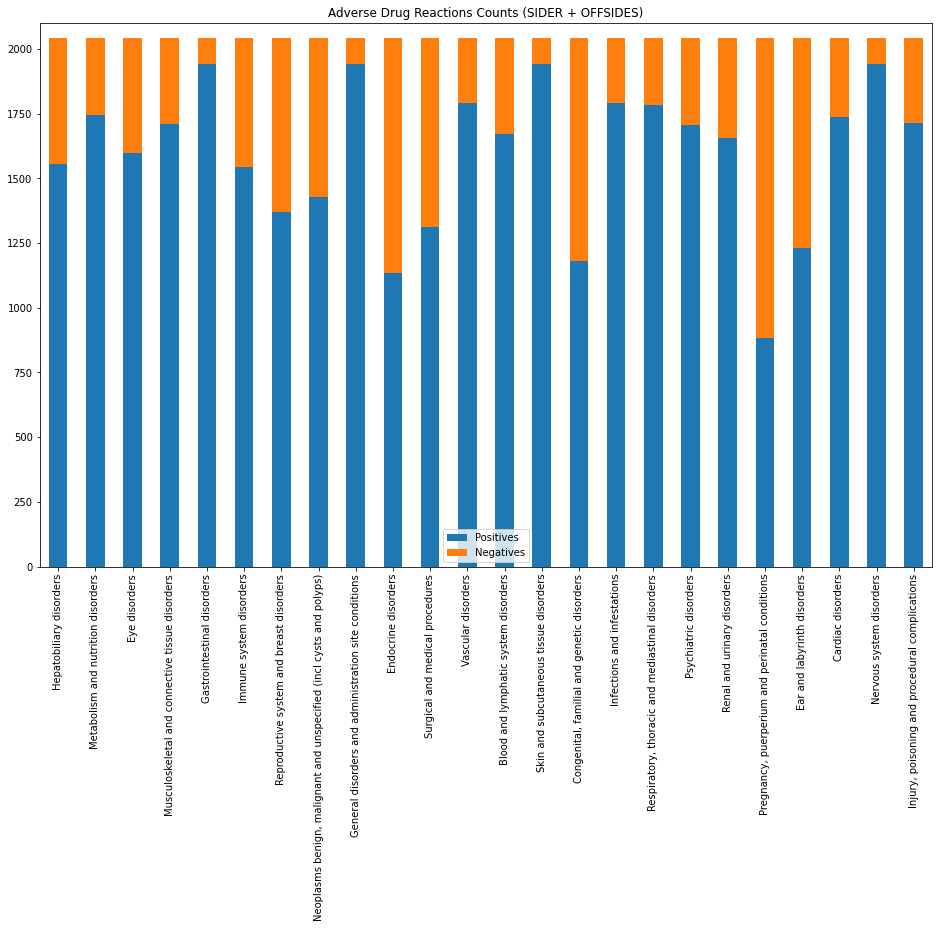

In [44]:
df_all = pd.read_csv("./dataframes/df_all.csv")  # (2043, 25)

# New counts (SIDER + OFFSIDES)
df_all_y = df_all.drop("smiles", axis=1)
da2 = {"Positives": df_all_y.sum(axis=0), "Negatives": 2043 - df_all_y.sum(axis=0)}
counts = pd.DataFrame(data=da2)
counts.plot(kind='bar', figsize=(16, 10), title="Adverse Drug Reactions Counts (SIDER + OFFSIDES)", ylim=(0, 2100),
            stacked=True)

As it is possible to see, most of the labels became even more imbalanced with the exception of the labels that had a minority in the positive examples.

In [45]:
# Repeat process of dataframe transformation with dataframe SIDER + OFFSIDES
df_off_y, df_off_mols = create_original_df(usedf=True, file=df_all, write_s=False, write_off=False)
df_off_mols.drop("smiles", axis=1, inplace=True)

df_off_mols_train, df_off_mols_test, y_off_train, y_off_test = train_test_split(df_off_mols, df_off_y, test_size=0.2,
                                                                                random_state=seed)

# Create X datasets with fingerprint length
X_off_all, _, _, _ = createfingerprints(df_off_mols, length=1125)
X_off_train_fp, _, _, _ = createfingerprints(df_off_mols_train, length=1125)
X_off_test_fp, _, _, _ = createfingerprints(df_off_mols_test, length=1125)

# Selects and create descriptors dataset
df_off_desc = createdescriptors(df_off_mols)  # Create all descriptors

# Splits in train and test
df_off_desc_base_train, df_off_desc_base_test = train_test_split(df_off_desc, test_size=0.2, random_state=seed)

# Creates a dictionary with key = class label and value = dataframe with fingerprint + best K descriptors for that label
X_off_train_dic, X_off_test_dic, selected_off_cols = create_dataframes_dic(df_off_desc_base_train,
                                                                           df_off_desc_base_test, X_off_train_fp,
                                                                           X_off_test_fp, y_off_train, out_names,
                                                                           score_func=f_classif, k=3)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 64.60it/s]


In [46]:
test_scores_sioff = test_score_multi_report(X_off_train_dic, y_off_train, X_off_test_dic, y_off_test, out_names,
                                            modelname=best_model_by_label, spec_params=best_model_params_by_label,
                                            random_state=seed, verbose=False, balancing=True, n_jobs=-2, plot=False)

 29%|████████████████████████▏                                                          | 7/24 [10:24<26:10, 92.37s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 38%|███████████████████████████████▏                                                   | 9/24 [13:14<22:31, 90.12s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 42%|██████████████████████████████████▏                                               | 10/24 [14:05<18:13, 78.08s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 58%|███████████████████████████████████████████████▊                                  | 14/24 [20:25<15:22, 92.25s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [26:39<06:38, 79.66s/it]C:\Users\20 may 2020\.conda\envs\my-rdkit-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [33:42<00:00, 84.25s/it]


In [47]:
print("Test scores for SIDER + OFFSIDE")
test_scores_sioff

Test scores for SIDER + OFFSIDE


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Prec-Rec
Hepatobiliary disorders,0.852,0.758,0.594,0.587,0.877,0.828,0.871
Metabolism and nutrition disorders,0.910,0.839,0.571,0.562,0.935,0.886,0.928
Eye disorders,0.875,0.785,0.552,0.547,0.914,0.839,0.855
Musculoskeletal and connective tissue disorders,0.909,0.836,0.551,0.545,0.949,0.872,0.908
Gastrointestinal disorders,0.966,0.934,0.547,0.544,0.969,0.962,0.980
Immune system disorders,0.828,0.714,0.493,0.514,0.921,0.751,0.792
Reproductive system and breast disorders,0.768,0.665,0.582,0.580,0.802,0.737,0.794
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.788,0.667,0.508,0.508,0.808,0.769,0.798
General disorders and administration site conditions,0.968,0.939,0.521,0.517,0.982,0.955,0.966
Endocrine disorders,0.618,0.553,0.539,0.541,0.655,0.585,0.600


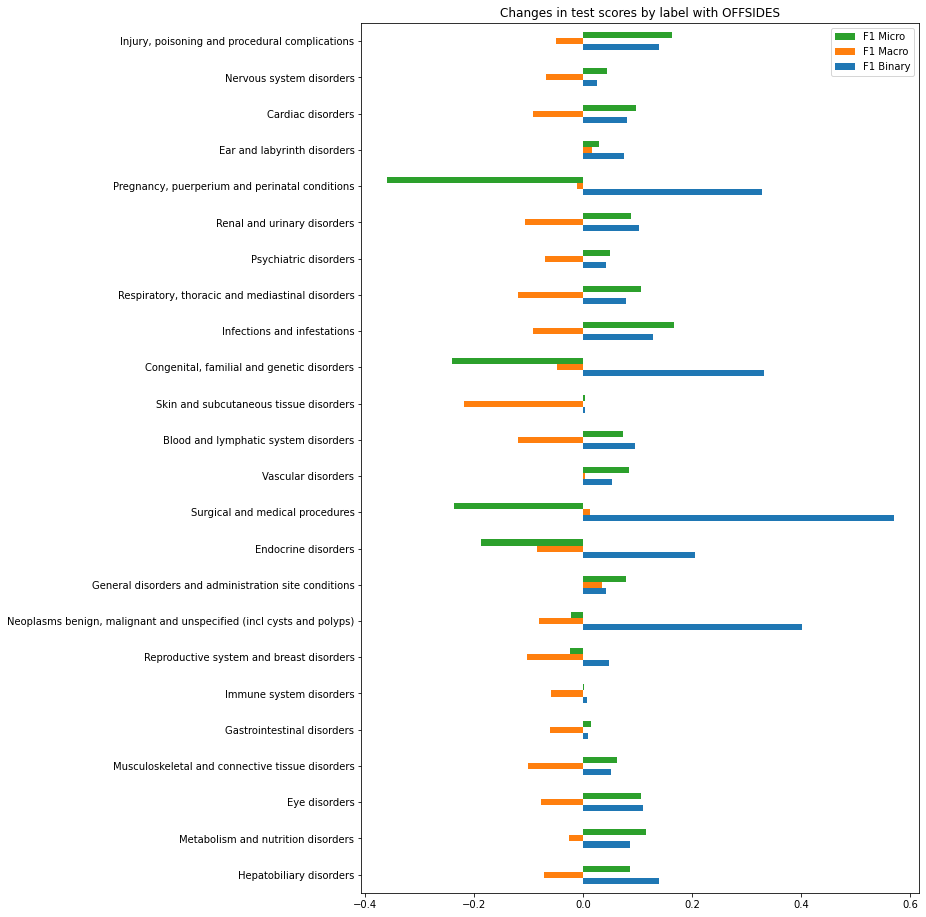

In [48]:
diff_offsides = test_scores_sioff - test_scores_best_model
ax2 = diff_offsides.plot(kind="barh", y=["F1 Binary", "F1 Macro", "F1 Micro"], 
                         title="Changes in test scores by label with OFFSIDES",legend="reverse", figsize = (10,16))

As we can see from the previous results, the biggest and only improvements when combining SIDER and OFFSIDES were in classes that had very low recall since the addition OFFSIDES dataset greatly increased the number of positives examples, thus balancing the dataset. But, even with these improvements, the overall performance of the models was worse after the merge of the datasets.

### 3.3 Future Work
As can be seen during this paper, the main problem faced during this work was the imbalance of the datasets, so this could be the focus of improvement in future related work.
One of the possibilities to try to avoid this could be to break down the used SOCs in their components. SOCs are the highest level in the MedDRA hierarchy and they encompass multiple more specific reactions so, in theory breaking down these SOCs in their lower level would reduce the number of positive examples in each of them.

The other possibility could be in the model development by trying other types of models such as deep learning or methods of over or under-sampling, for example using the "class weights" in some of the scikit-learn models.



In [49]:
def create_dataframes_dic(df_desc_base_train, df_desc_base_test, X_train_fp, X_test_fp, y_train, out_names,
                          score_func=f_classif, k=3):
    # Create 3 dictionaries, one with the train dataframes, one with the test dataframes and one with the selected
    # features for each label

    # Initialize dictonaries
    train_series_dic = {name: None for name in out_names}
    test_series_dic = {name: None for name in out_names}
    selected_name = {name: None for name in out_names}
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    # For each of the tasks build the train and test dataframe with the selected descriptors
    for name in tqdm(out_names):
        
        # Select best descriptors for the task
        sel_col = select_best_descriptors(df_desc_base_train, y_train[name], score_func=score_func, k=k)
        selected_name[name] = sel_col  # Keep track of selected columns
        df_desc_train = df_desc_base_train.loc[:, sel_col].copy()  # Get train dataframe with only selected columns
        df_desc_test = df_desc_base_test.loc[:, sel_col].copy()  # Get test dataframe with only selected columns
        df_train = pd.concat([df_train, df_desc_train], axis=1)
        df_test = pd.concat([df_test, df_desc_test], axis=1)
    X_train = pd.concat([X_train_fp, df_train], axis=1)
    X_test = pd.concat([X_test_fp, df_test], axis=1)
    return(X_train, X_test)

X_tr, X_te = create_dataframes_dic(df_desc_base_train, df_desc_base_test, X_train_fp,
                                                               X_test_fp, y_train, out_names, score_func=f_classif, k=3)

X_tr = X_tr.loc[:, ~X_tr.columns.duplicated()]
X_te = X_te.loc[:, ~X_te.columns.duplicated()]

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 113.03it/s]


In [52]:
!pip install scikit-multilearn

In [54]:
import pickle

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multiclass import OneVsRestClassifier# Using pipeline for applying logistic regression and one vs rest classifier
RF_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(RandomForestClassifier())),
            ])

for col in y_train.columns:
    
    # Training logistic regression model on train data
    model = RF_pipeline.fit(X_tr, y_train[col])
    pickle.dump(model, open(col, 'wb'))
    # calculating test accuracy
    prediction = RF_pipeline.predict(X_te)
    print('Test accuracy is {}'.format(accuracy_score(y_test[col], prediction)))
    print("\n")

Test accuracy is 0.6678321678321678


Test accuracy is 0.7237762237762237


Test accuracy is 0.6748251748251748


Test accuracy is 0.7202797202797203


Test accuracy is 0.9265734265734266


Test accuracy is 0.6678321678321678


Test accuracy is 0.6853146853146853


Test accuracy is 0.7552447552447552


Test accuracy is 0.8846153846153846


Test accuracy is 0.7692307692307693


Test accuracy is 0.8286713286713286


Test accuracy is 0.7692307692307693


Test accuracy is 0.7062937062937062


Test accuracy is 0.9090909090909091


Test accuracy is 0.8321678321678322


Test accuracy is 0.6748251748251748


Test accuracy is 0.7237762237762237


Test accuracy is 0.7727272727272727


Test accuracy is 0.6678321678321678


Test accuracy is 0.8916083916083916


Test accuracy is 0.6293706293706294


Test accuracy is 0.7272727272727273


Test accuracy is 0.8916083916083916


Test accuracy is 0.6538461538461539


